In [9]:
import pandas as pd
import numpy as np
from gurobipy import *
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [10]:
BUILD_COST = 600
CAPACITY = 1000

In [11]:
k = 50
eps = 10**-4
D = pd.read_csv("./data/2.6/Demand.txt", delimiter="\t", header=None).to_numpy()
kmean = KMeans(k, max_iter=1000)
kmean.fit(D[:, 1:3])

centers = kmean.cluster_centers_
centers_t = []
for id, point in enumerate(centers):
    for id1, shop in enumerate(D):
        if (point == shop[1:3]).all():
            point += eps
            print(id, point, id1, shop[1:3])
            break
    centers_t.append(list(point))

centers_t = np.array(centers_t)

with open("./data/2.6/Facility.txt", "w") as temp:
    for id, i in enumerate(centers_t):
        print(id + 1, *np.round(i, 3), CAPACITY, BUILD_COST, file=temp)

with open("./data/2.6/TransCost.txt", "w") as temp:
    for j in centers_t:
        for i in D:
            print(np.round(np.linalg.norm(j - i[1:3]), 3), end=" ", file=temp)
        print("", file=temp)


20 [6.5101 6.4941] 124 [6.51  6.494]
33 [6.9541 4.6471] 169 [6.954 4.647]


In [12]:
f = pd.read_csv("./data/2.6/Facility.txt", delimiter=" ", header=None).dropna(axis=1).to_numpy()
t = pd.read_csv("./data/2.6/TransCost.txt", delimiter=" ", header=None).dropna(axis=1).to_numpy()
D = pd.read_csv("./data/2.6/Demand.txt", delimiter="\t", header=None).to_numpy()
f

array([[   1.   ,    5.452,    3.236, 1000.   ,  600.   ],
       [   2.   ,    4.656,    4.449, 1000.   ,  600.   ],
       [   3.   ,    5.872,    5.848, 1000.   ,  600.   ],
       [   4.   ,    3.364,    3.747, 1000.   ,  600.   ],
       [   5.   ,    6.31 ,    4.701, 1000.   ,  600.   ],
       [   6.   ,    6.294,    2.853, 1000.   ,  600.   ],
       [   7.   ,    4.186,    2.792, 1000.   ,  600.   ],
       [   8.   ,    2.913,    4.69 , 1000.   ,  600.   ],
       [   9.   ,    2.656,    2.801, 1000.   ,  600.   ],
       [  10.   ,    5.225,    4.533, 1000.   ,  600.   ],
       [  11.   ,    6.734,    5.504, 1000.   ,  600.   ],
       [  12.   ,    6.845,    2.147, 1000.   ,  600.   ],
       [  13.   ,    2.527,    3.581, 1000.   ,  600.   ],
       [  14.   ,    5.302,    2.6  , 1000.   ,  600.   ],
       [  15.   ,    4.72 ,    6.707, 1000.   ,  600.   ],
       [  16.   ,    5.185,    3.853, 1000.   ,  600.   ],
       [  17.   ,    6.28 ,    6.163, 1000.   ,  600.   

In [13]:
model = Model("2.6.1")
x = model.addMVar(t.shape, vtype=GRB.CONTINUOUS, name="x")
c = model.addMVar((f.shape[0]), vtype=GRB.BINARY, name="c")
model.update()

model.addConstr(x.sum(axis=1) <= CAPACITY * c)
model.addConstr(x.sum(axis=0) >= D[:, -1])

model.setObjective((c * BUILD_COST).sum() + (x * t).sum(), sense=GRB.MINIMIZE)

model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Academic license 2395694 - for non-commercial use only - registered to tr___@gmail.com
Optimize a model with 250 rows, 10050 columns and 20050 nonzeros
Model fingerprint: 0x7a30923d
Variable types: 10000 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e-03, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+00, 4e+01]
Found heuristic solution: objective 40673.790000
Presolve time: 0.03s
Presolved: 250 rows, 10050 columns, 20050 nonzeros
Found heuristic solution: objective 40022.575000
Variable types: 10000 continuous, 50 integer (50 binary)

Root relaxation: objective 3.906799e+03, 339 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |    

In [14]:
if model.status == GRB.Status.OPTIMAL:
    with open("./out/2.6.out", "w") as temp:
        print(0, end=" ", file=temp)
        for i in range(f.shape[0]):
            print(int(abs(np.round(c[i].X))), end=" ", file=temp)
        print("", file=temp)
        for i in range(f.shape[0]):
            if c[i].X:
                for j in range(D.shape[0]):
                    if x[i, j].X != 0:
                        print(f"{i + 1} {j + 1} {x[i, j].X}", file=temp)
        print(model.ObjVal, file=temp)

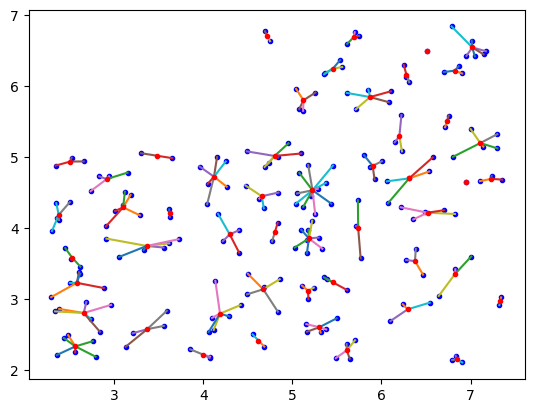

In [15]:
labels = kmean.labels_
plt.scatter(D[:, 1], D[:, 2], color="blue", marker=".", zorder=2)
plt.scatter(centers[:, 0], centers[:, 1], color="red", zorder=5, marker=".")
for id, i in enumerate(D):
    plt.plot([i[1], centers[labels[id]][0]], [i[2], centers[labels[id]][1]])

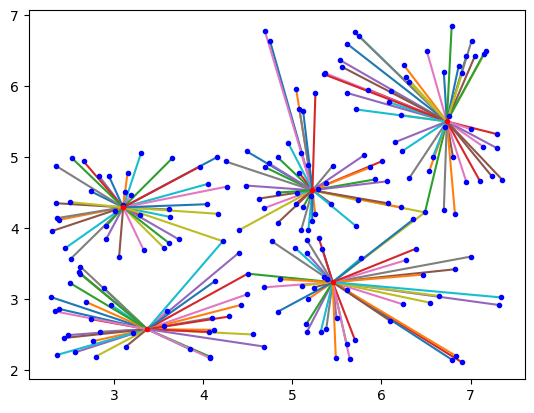

In [16]:
for i in range(c.shape[0]):
    if int(abs(np.round(c[i].X))):
        plt.scatter(f[i, 1], f[i, 2], color="red", zorder=5, marker=".")
    for j in range(D.shape[0]):
        if x[i, j].X != 0:
            plt.plot([f[i, 1], D[j, 1]], [f[i, 2], D[j, 2]])
plt.scatter(D[:, 1], D[:, 2], color="blue", marker=".", zorder=2)